# **Domain Adaptation to train model-independent classifiers in High Energy Physics**

In this notebook we want to build a simple DNN and train it using a typical HEP approach. Our dataset in this case will consist of only SM events.

# Check the SM dataset

This new dataset is very similar to the previous one, except that it is smaller and the BSM models have been dropped.

Note that in this dataset all the events labelled as **isVBF** are SM VBF events.

In [ ]:
import pandas as pd


In [ ]:
# IF USING COLAB, Uncomment and run the next lines and comment the next block; OTHERWISE leave all as is
#%pip install pickle5
#import pickle5 as pickle
#!wget https://pandora.infn.it/public/123c9b/dl/dataset_SM.pkl
#with open('dataset_SM.pkl', "rb") as fh:
#  df = pickle.load(fh)
# END COLAB BLOCK

In [ ]:
# IF NOT USING COLAB, please use the standard code below
df = pd.read_pickle('https://pandora.infn.it/public/123c9b/dl/dataset_SM.pkl')
# END NON COLAB BLOCK

In [ ]:
#BACK to standard flow

pd.set_option('display.max_columns', None)
df

## How many events of each kind do we have?

Let's know check how many events of each process we have in our dataset. In this case we opted for a balanced dataset composed by **VBF**, **ggH** and **BKG** processes in equal proportions.

In [2]:
for col in df.columns[24:35]:
    print (col, len(df[df[col]==1]))

isVBF 8590
isGGH 8590
isBKG 8590


# Define the a simple DNN

We now want to build a simple DNN model. For the sake of clarity we maintain the same structure of the ADNN class.

In [3]:
import tensorflow as tf
# import optuna
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


In [4]:
class SimpleNeuralNetwork ( tf.Module ):
    def __init__ (self, nEpochs, learning_rate, N_NODES, n_layers, n_features, n_outputsC=3):
        self.learning_rate = learning_rate
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        self.nEpochs = nEpochs
        self.N_NODES = N_NODES
        self.n_layers = n_layers
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.weights = self.build (self.n_features, self.N_NODES)
        
                                
    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        for i in range(self.n_layers):
            self.model1.add(Dense (self.N_NODES, activation = 'relu'))
        self.model1.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))      
        
        return self.model1.weights
     
    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, X_val, Y_val, show_loss = False):
        losses = []
        losses_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_val = self._train (X, Y, X_val, Y_val)
                losses.append ( l )
                losses_val.append ( l_val )

        losses = np.array(losses)               
        losses_val = np.array(losses_val)
               
        plt.plot (losses, color = "c", label='Training set')
        plt.plot (losses_val, color ='tab:blue', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss")
        plt.legend(frameon=False)
        plt.show()
        
        ca = tf.keras.metrics.CategoricalAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        
    def set_epochs(self, epochs):
        self.nEpochs = epochs
        
    # Applies a pre-processing to the input features and returns the classifier representation.
    #@tf.function
    def predict_proba (self, X):
        ppX = (X - self.means)/self.sigmas
        return  tf.clip_by_value ( self.model1 (ppX) , 1e-7, 1. - 1e-7 )


    @tf.function
    def _train (self, X, Y, X_val, Y_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)

        with tf.GradientTape() as gt:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the classifier
            cce = tf.keras.losses.CategoricalCrossentropy()
            loss = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
            ## Validation set
            cce_val = tf.keras.losses.CategoricalCrossentropy()
            loss_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            
            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weights )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weights) )
        
        return loss, loss_val

# Training of the simple DNN model

## Extract the input features and labels from the original dataset and split in training (80%) and validation (20%)

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

features = df.columns[:24]

NDIM = len(features)

for col in df.columns:
    df[col] = np.hstack(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df = shuffle(df)

# Perform the splitting and define training and validation datasets
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]

X = df_train.values[:,0:NDIM]
Y = df_train.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG

X_val = df_val.values[:,0:NDIM]
Y_val = df_val.values[:,NDIM:NDIM+3] # isVBF, isGGH, isBKG


## Build the simple DNN model and define the needed parameters

In [ ]:
dnn = SimpleNeuralNetwork(500, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X.shape[1])

# Save initial set of weights (before training) to re-initialize the ADNN in later steps.
# Useful if we want to restart always from the same starting point during the optimization studies.
dnn.save_weights("my_simpleDNN_model_init")

## Perform the training

100%|██████████| 500/500 [00:13<00:00, 38.30it/s]


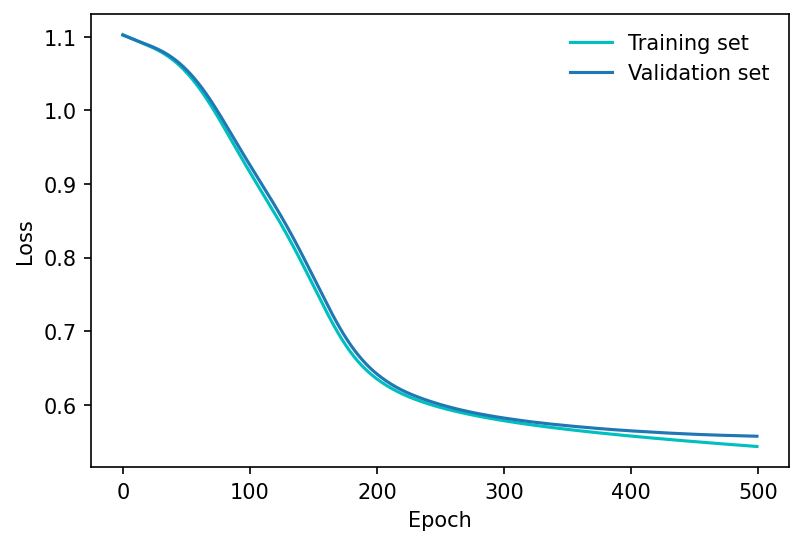

In [7]:
acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))

# How do we quantify the simple DNN performance

To compare with the ADNN approach, we want to know the accuracy and the performance of the simple DNN on the models belonging to the target domain, i.e. BSM models.

To achieve this, let's resume the ADNN dataset and use it to evaluate the simple DNN.

## Plot the probability distributions for the three output nodes of C

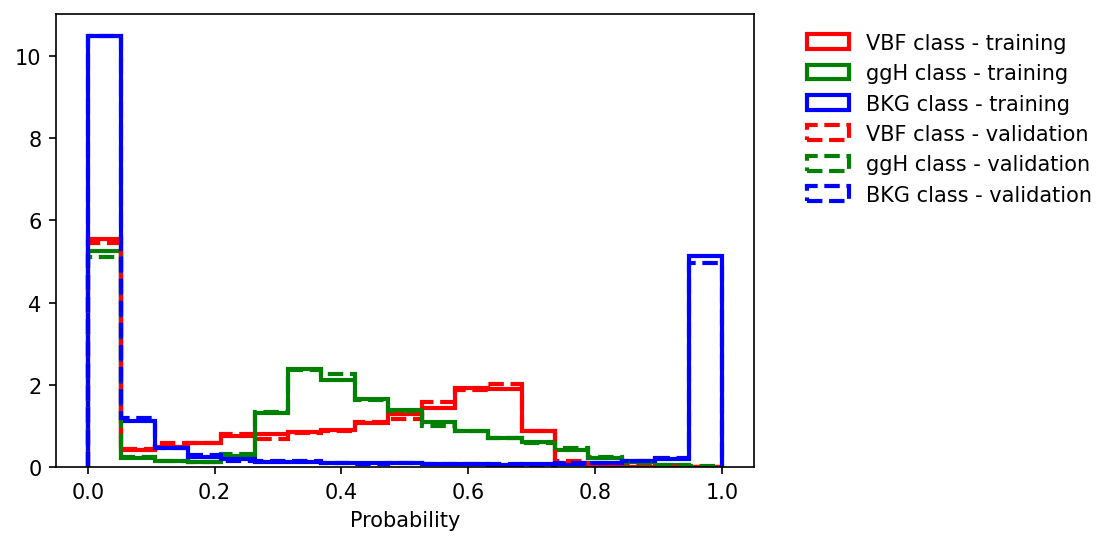

In [8]:
Y_predict_train = dnn.predict_proba(X)
Y_predict_val = dnn.predict_proba(X_val)

axis = np.linspace(0,1,20)

plt.hist(Y_predict_train[:,0].numpy(), bins = axis, label = 'VBF class - training',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predict_train[:,1].numpy(), bins = axis, label = 'ggH class - training',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predict_train[:,2].numpy(), bins = axis, label = 'BKG class - training',  histtype='step', color='b',  density=True, linewidth=2 )
plt.hist(Y_predict_val[:,0].numpy(), bins = axis, label = 'VBF class - validation',  histtype='step', color='r',  density=True, linewidth=2, linestyle="dashed" )
plt.hist(Y_predict_val[:,1].numpy(), bins = axis, label = 'ggH class - validation',  histtype='step', color='g',  density=True, linewidth=2, linestyle="dashed" )
plt.hist(Y_predict_val[:,2].numpy(), bins = axis, label = 'BKG class - validation',  histtype='step', color='b',  density=True, linewidth=2, linestyle="dashed" )
plt.xlabel("Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

## Plot the probability distributions for labelled events

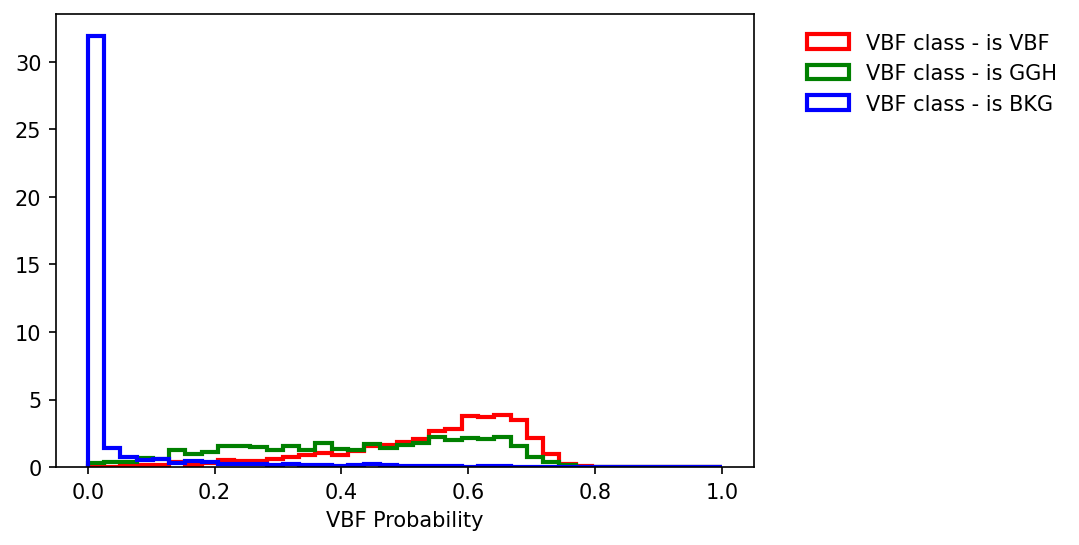

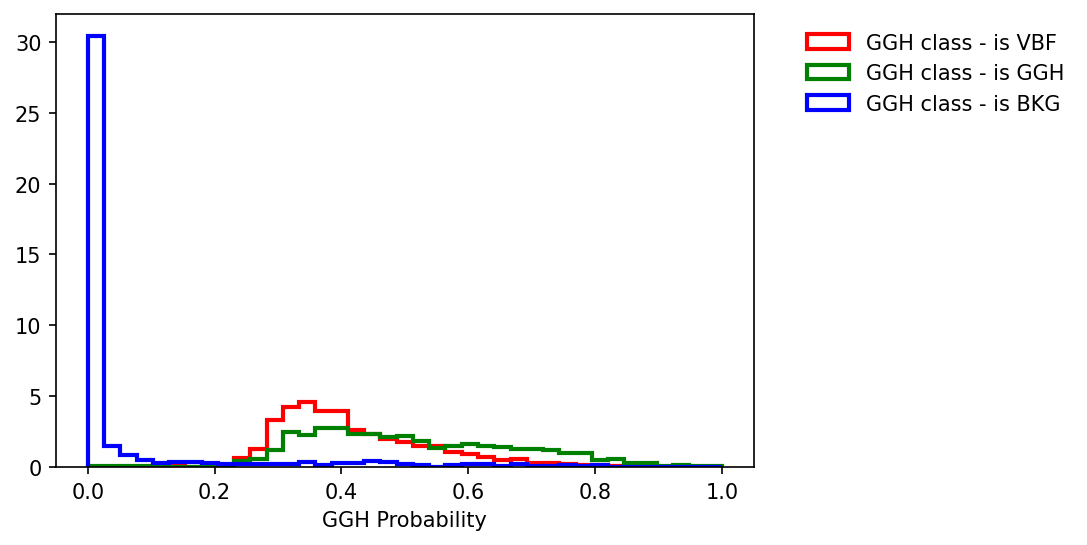

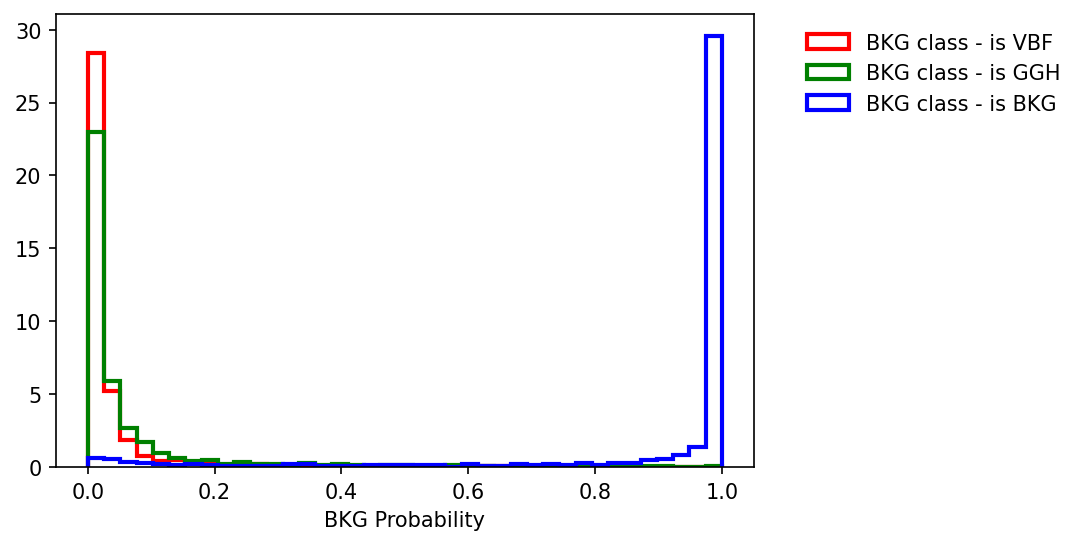

In [9]:
# Explanation of the sintax used below
# adnn.predict_proba( df_val[ df_val['isVBF']==1 ].values[:,0:NDIM] )[:,0]
#                                      ^                    ^           ^
#                                      |                    |           |
#                                select VBF events          |           |
#                                               get the input features  |
#                                                             select the VBF output node (i.e. node 0)
pred_isvbf = dnn.predict_proba( df_val[ df_val['isVBF']==1 ].values[:,0:NDIM] )
Y_predvbf_isvbf = pred_isvbf[:,0]
Y_predggh_isvbf = pred_isvbf[:,1]
Y_predbkg_isvbf = pred_isvbf[:,2]

pred_isggh = dnn.predict_proba( df_val[ df_val['isGGH']==1 ].values[:,0:NDIM] )
Y_predvbf_isggh = pred_isggh[:,0]
Y_predggh_isggh = pred_isggh[:,1]
Y_predbkg_isggh = pred_isggh[:,2]

pred_isbkg = dnn.predict_proba( df_val[ df_val['isBKG']==1 ].values[:,0:NDIM] )
Y_predvbf_isbkg = pred_isbkg[:,0]
Y_predggh_isbkg = pred_isbkg[:,1]
Y_predbkg_isbkg = pred_isbkg[:,2]

axis = np.linspace(0,1,40)

plt.hist(Y_predvbf_isvbf.numpy(), bins = axis, label = 'VBF class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predvbf_isggh.numpy(), bins = axis, label = 'VBF class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predvbf_isbkg.numpy(), bins = axis, label = 'VBF class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("VBF Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

plt.hist(Y_predggh_isvbf.numpy(), bins = axis, label = 'GGH class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predggh_isggh.numpy(), bins = axis, label = 'GGH class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predggh_isbkg.numpy(), bins = axis, label = 'GGH class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("GGH Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

plt.hist(Y_predbkg_isvbf.numpy(), bins = axis, label = 'BKG class - is VBF',  histtype='step', color='r',  density=True, linewidth=2 )
plt.hist(Y_predbkg_isggh.numpy(), bins = axis, label = 'BKG class - is GGH',  histtype='step', color='g',  density=True, linewidth=2 )
plt.hist(Y_predbkg_isbkg.numpy(), bins = axis, label = 'BKG class - is BKG',  histtype='step', color='b',  density=True, linewidth=2 )
plt.xlabel("BKG Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()

## Let's calculate the accuracy

In [10]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X = df_val.values[:,0:NDIM]
Y_true = df_val.values[:,NDIM:NDIM+3]
Y_pred = dnn.predict_proba(X)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))


Classifier categorical accuracy =  0.7175305765870704


## Plot the probability distributions of different VBF signal models

Note that to do this we reload the original dataset that contained also the BSM events, and we evaluate the simple DNN on this dataset.

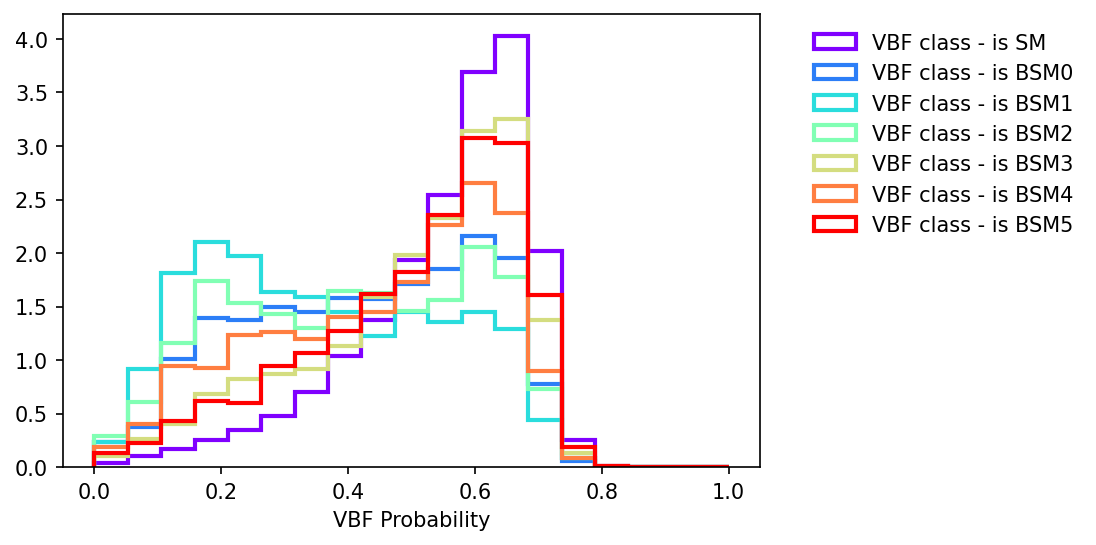

In [11]:
# IF NOT USING COLAB, USE LINES BELOW; OTHERWISE COMMENT THEM AND UNCOMMENT NEXT BLOCK
df_bsm = pd.read_pickle('https://pandora.infn.it/public/488317/dl/dataset_DA.pkl')

#BLOCK FOR COLAB
#!wget https://pandora.infn.it/public/488317/dl/dataset_DA.pkl
#with open('dataset_DA.pkl', "rb") as fh2:
#  df_bsm = pickle.load(fh2)
#END NON COLAB BLOCK

color = cm.rainbow(np.linspace(0, 1, 7))

pred_isvbfsm = dnn.predict_proba( df_bsm[ df_bsm['isSM']==1 ].values[:,0:NDIM] )
Y_predvbf_isvbfsm = pred_isvbfsm[:,0]
Y_predggh_isvbfsm = pred_isvbfsm[:,1]
Y_predbkg_isvbfsm = pred_isvbfsm[:,2]

axis = np.linspace(0,1,20)
plt.hist(Y_predvbf_isvbfsm.numpy(), bins = axis, label = 'VBF class - is SM',  histtype='step', color=color[0],  density=True, linewidth=2 )

for i in range(6):
    pred_isbsm = dnn.predict_proba( df_bsm[ df_bsm['isBSM'+str(i)]==1 ].values[:,0:NDIM] )
    Y_predvbf_isbsm = pred_isbsm[:,0]
    Y_predggh_isbsm = pred_isbsm[:,1]
    Y_predbkg_isbsm = pred_isbsm[:,2]

    plt.hist(Y_predvbf_isbsm.numpy(), bins = axis, label = 'VBF class - is BSM'+str(i),  histtype='step', color=color[i+1],  density=True, linewidth=2 )

plt.xlabel("VBF Probability")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
plt.show()



Wow, that's really bad...

# Summary of the simple DNN performance

Let's finish this part by computing the DNN accuracy on BSM models, as well ad the metrics used to evaluate the level of agreement between SM and BSM distributions.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()

KS between isSM and isBSM0 -->  KstestResult(statistic=0.3171852899575672, pvalue=3.98671179874338e-126)
KS between isSM and isBSM1 -->  KstestResult(statistic=0.4543847241867044, pvalue=1.7193317500124774e-263)
KS between isSM and isBSM2 -->  KstestResult(statistic=0.3606789250353607, pvalue=7.934616175112044e-164)
KS between isSM and isBSM3 -->  KstestResult(statistic=0.12588401697312587, pvalue=6.165730880635781e-20)
KS between isSM and isBSM4 -->  KstestResult(statistic=0.24045261669024046, pvalue=4.007062568788279e-72)
KS between isSM and isBSM5 -->  KstestResult(statistic=0.12906647807637905, pvalue=6.1404391511881405e-21)
KS between isBSM0 and isBSM1 -->  KstestResult(statistic=0.15876944837340876, pvalue=1.6421494028598016e-31)
KS between isBSM0 and isBSM2 -->  KstestResult(statistic=0.05693069306930693, pvalue=0.0002084046194014445)
KS between isBSM0 and isBSM3 -->  KstestResult(statistic=0.2012022630834512, pvalue=1.774922732323989e-50)
KS between isBSM0 and isBSM4 -->  Kstes

/tmp/ipykernel_237/4116565486.py:27: UserWarning: p-value capped: true value larger than 0.25
  print(anderson_ksamp(samples_for_ad))


Anderson_ksampResult(statistic=-4.2293133437719606, critical_values=array([0.67035496, 1.28559405, 1.65762361, 1.98147181, 2.36012766,
       2.61733951, 3.15293558]), significance_level=0.25)
Classifier categorical accuracy for SM-BSM model mixture = 0.636933129009986
Classifier categorical accuracy for model isSM = 0.6969468348461629
Fraction of isSM events classified as VBF = 0.745


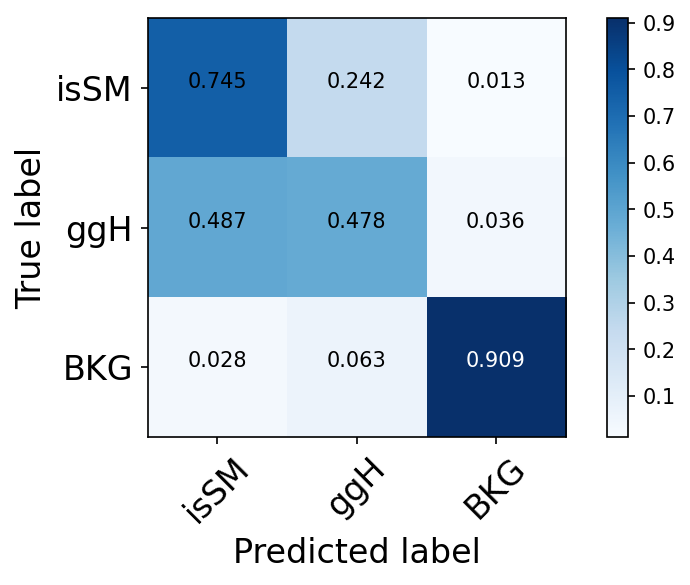

Classifier categorical accuracy for model isBSM0 = 0.6766709890368974
Fraction of isBSM0 events classified as VBF = 0.441


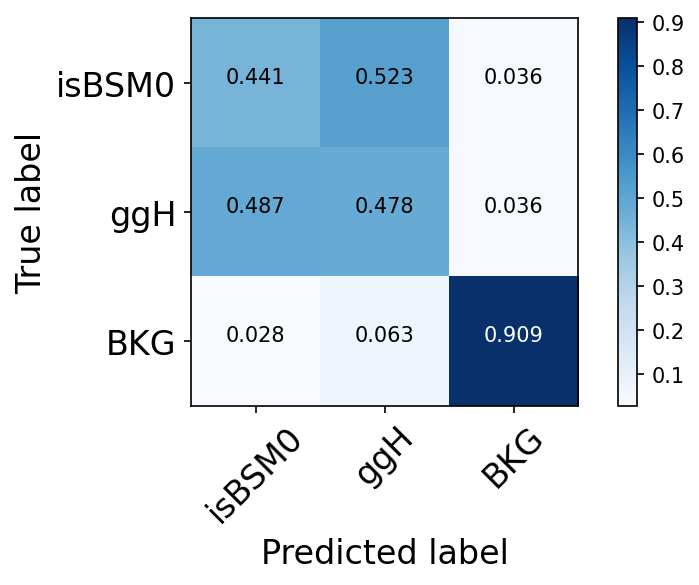

Classifier categorical accuracy for model isBSM1 = 0.6679948131557232
Fraction of isBSM1 events classified as VBF = 0.311


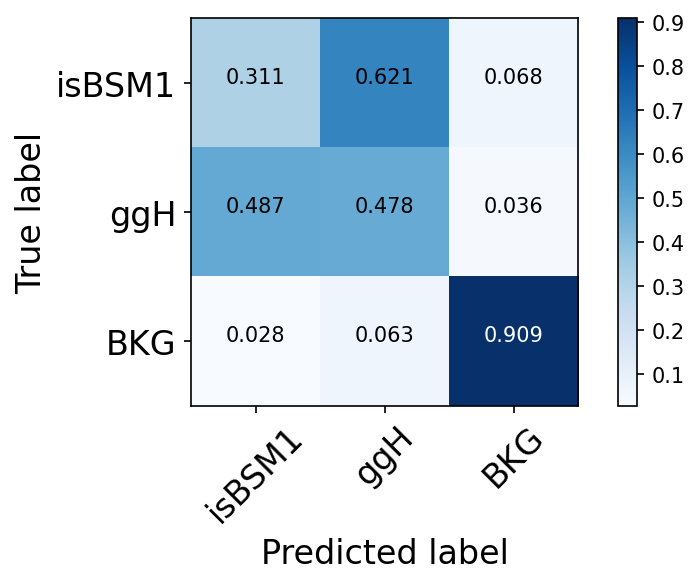

Classifier categorical accuracy for model isBSM2 = 0.6734881527761405
Fraction of isBSM2 events classified as VBF = 0.393


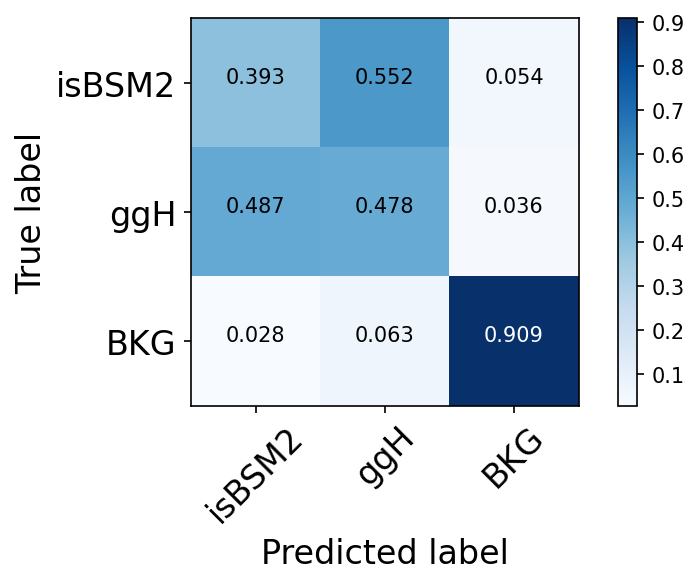

Classifier categorical accuracy for model isBSM3 = 0.6892608746905576
Fraction of isBSM3 events classified as VBF = 0.63


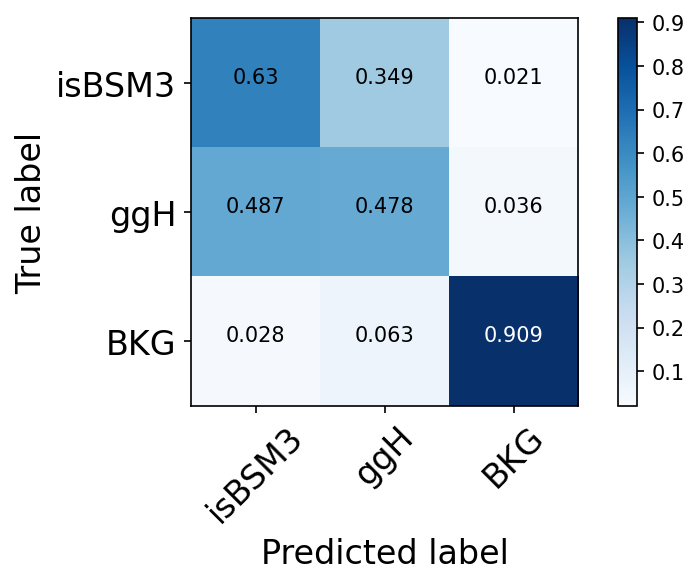

Classifier categorical accuracy for model isBSM4 = 0.6819049864434752
Fraction of isBSM4 events classified as VBF = 0.519


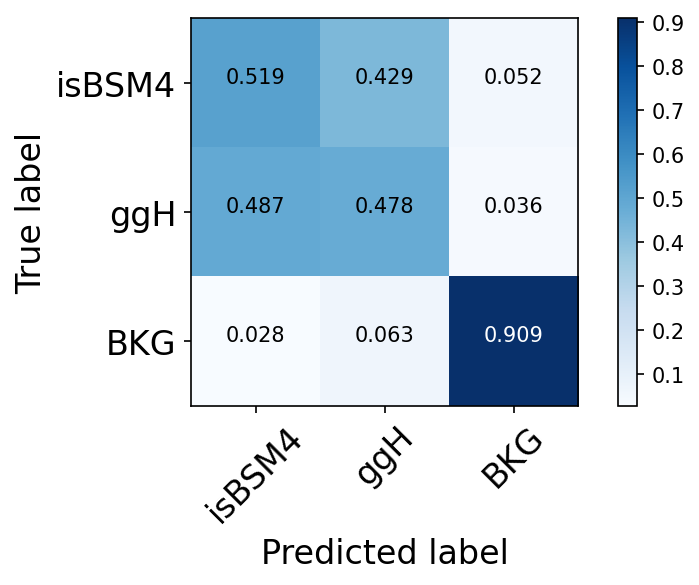

Classifier categorical accuracy for model isBSM5 = 0.6890958387362961
Fraction of isBSM5 events classified as VBF = 0.627


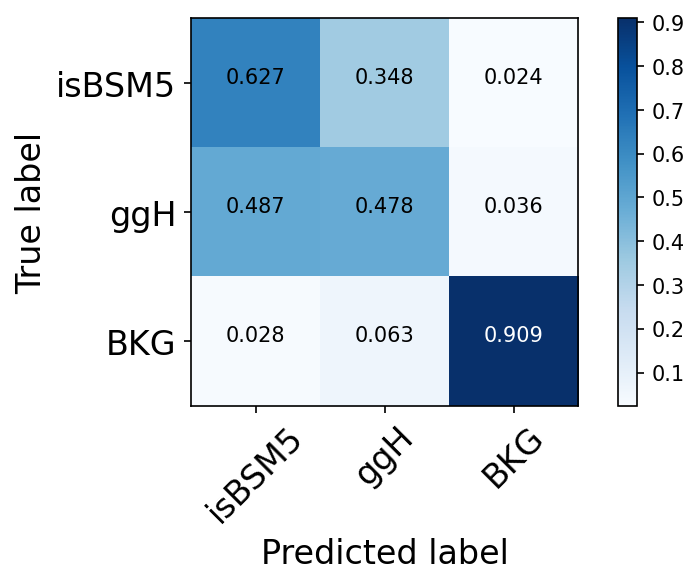

In [13]:
# Let's try to compute a 2-sample Kolmogorov-Smirnov test on each pair of different models.
# The larger (smaller) is the p-value (test statistic) the higher is the compatibility between the distributions.
preds = {}
preds['isSM'] = Y_predvbf_isvbfsm
for i in range(6):
    preds['isBSM'+str(i)] = dnn.predict_proba( df_bsm[ df_bsm['isBSM'+str(i)]==1 ].values[:,0:NDIM] )[:,0]

ks_test_stat = 0
comb=0
for i in range(7):
    for j in range(i,6):
        label1 = 'isSM' if i==0 else 'isBSM'+str(i-1)
        label2 = 'isBSM'+str(j)
        stat, pval = ks_2samp(preds[label1],preds[label2])
        ks_test_stat += stat
        comb+=1
        print ( "KS between %s and %s --> " %(label1,label2),ks_2samp(preds[label1],preds[label2]) )
ks_test_stat = ks_test_stat/comb
print("Average K-S test stat = ", ks_test_stat)

# An interesting alternative is the k-sample Anderson-Darling test.
# It tests the null hypothesis that k-samples are drawn from the same population without having to specify the distribution function of that population. 
samples_for_ad = np.array( (preds['isSM'].numpy(), preds['isBSM0'].numpy(), preds['isBSM1'].numpy(), 
                         preds['isBSM2'].numpy(), preds['isBSM3'].numpy(), preds['isBSM4'].numpy(),
                         preds['isBSM5'].numpy()) ).T

print(anderson_ksamp(samples_for_ad))

#And now the categorical accuracy for each of the 6 BSM models not seen in this training

X      = df_bsm.values[:,0:NDIM]
Y_true = df_bsm.values[:,NDIM:NDIM+3]

Y_pred = dnn.predict_proba(X)

Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy for SM-BSM model mixture = %s" %(accuracy_score(Y_true_max, Y_pred_max)))

for i in range(7):
    label = 'isSM' if i==0 else 'isBSM'+str(i-1)
    X      = df_bsm[ (df_bsm[label]==1) | (df_bsm['isBKG']==1) | (df_bsm['isGGH']==1) ].values[:,0:NDIM]
    Y_true = df_bsm[ (df_bsm[label]==1) | (df_bsm['isBKG']==1) | (df_bsm['isGGH']==1) ].values[:,NDIM:NDIM+3]

    Y_pred = dnn.predict_proba(X)

    Y_true_max = np.argmax(Y_true, axis=1)
    Y_pred_max = np.argmax(Y_pred, axis=1)
    print("Classifier categorical accuracy for model %s = %s" %(label, accuracy_score(Y_true_max, Y_pred_max)))
    
    C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
    C = np.around(C, decimals=3)
    print("Fraction of %s events classified as VBF = %s" %(label, C[0,0]))
    target_names = [label,'ggH','BKG']

    plt.figure()
    plot_confusion_matrix(C, classes=target_names, title='')
    plt.show(1) 